### Part A
#### A1

In [1]:
import nltk
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

raw_data = pd.read_csv('all/Train_rev1/Train_rev1.csv')
job = raw_data.sample(n=2500, random_state=99)

In [2]:
from nltk import word_tokenize
from string import punctuation

## Transfrom all words into lowercase and drop the punctuation
def preprocess(x):
    lowercase= x.lower()
    for p in punctuation:
        lowercase = lowercase.replace(p,'')
    return lowercase

token = job['FullDescription'].map(preprocess).map(word_tokenize)
token = token.reset_index()['FullDescription']
pos_tagging = token.map(nltk.pos_tag)

In [3]:
tags = []

def pos_series(x):
    for word, pos in x:
        tags.append(pos)
pos_tagging.map(pos_series)
pd.Series(tags).value_counts()[:5]

NN     156816
JJ      69903
IN      65426
NNS     50777
DT      50574
dtype: int64

As we can see, NN (Noun, singular or mass) is the most common POS in the job descriptions. Second most common POS is JJ (Adjective), followed by IN (Preposition or subordinating conjunction), NNS (Noun, plural) and DT (Determiner). 

#### Excluding Stopwords

In [4]:
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

filtered_sentence = [] 

def remove_stopwords(x):
    for w in x: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
token.map(remove_stopwords)
pos_tagging_without_stopwords = nltk.pos_tag(filtered_sentence)

tags_without_stopwords = []

for word, pos in pos_tagging_without_stopwords:
    tags_without_stopwords.append(pos)
pd.Series(tags_without_stopwords).value_counts()[:5]

NN     150812
JJ      72987
NNS     50230
VBG     25524
VBP     16890
dtype: int64

After removing stop words, NN (Noun, singular or mass) is still the most common POS in the job descriptions. JJ (Adjective) is still the second most common POS. NNS (Noun, plural) becomes the third most common POS. VBG (Verb, gerund or present participle) and VBP (Verb, non-3rd person singular present) become fourth and fifth common among all POS. 

#### A2

In [5]:
word_list = []

def pos_series(x):
    for word, pos in x:
        word_list.append(word)
pos_tagging.map(pos_series)

word_counts = pd.Series(word_list).value_counts()
word_rank = word_counts.rank(method='max',ascending=False)
top_100_words = word_counts[:100]

In [6]:
import math

top_100_words = top_100_words.reset_index()
top_100_words.columns = ['words','freq']
top_100_words['rank'] = top_100_words['freq'].rank(method='max',ascending=False)
top_100_words['log_freq'] = top_100_words['freq'].map(math.log)
top_100_words['log_rank'] = top_100_words['rank'].map(math.log)
top_100_words['norm_log_freq'] = (top_100_words['freq'] / (100*min(top_100_words['freq']))).map(math.log)

Text(0,0.5,'log(Freq)')

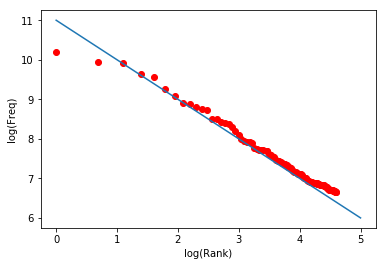

In [7]:
plt.plot(top_100_words['log_rank'],top_100_words['log_freq'],'ro')
plt.plot([0,5],[11,6])
plt.xlabel('log(Rank)')
plt.ylabel('log(Freq)')

It seems like our data do support Zipf's law. 

In [9]:
from statsmodels.formula.api import ols
formula = 'log_rank ~ 0 + norm_log_freq'
results = ols(formula, top_100_words).fit()
hypotheses = 'norm_log_freq = -1'
t_test = results.t_test(hypotheses)
print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.9677      0.004      8.692      0.000      -0.975      -0.960


#### A3

In [15]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [16]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
l = []
for word, tag in pos_tagging_without_stopwords:
    wntag = get_wordnet_pos(tag)
    if wntag is None:
        lemma = lemmatizer.lemmatize(word)
        l.append(lemma)
    else:
        lemma = lemmatizer.lemmatize(word, pos=wntag) 
        l.append(lemma)

pd.Series(l).value_counts()[:10]

work          5187
experience    4863
role          3133
team          3052
client        2994
business      2864
service       2438
skill         2320
sale          2209
within        2181
dtype: int64